# 权重衰减
***权重衰减是最广泛使用的正则化技术之一，也被称为L2正则化，在训练集的损失函数中加入惩罚项***

## 导入包

In [16]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

## 生成数据

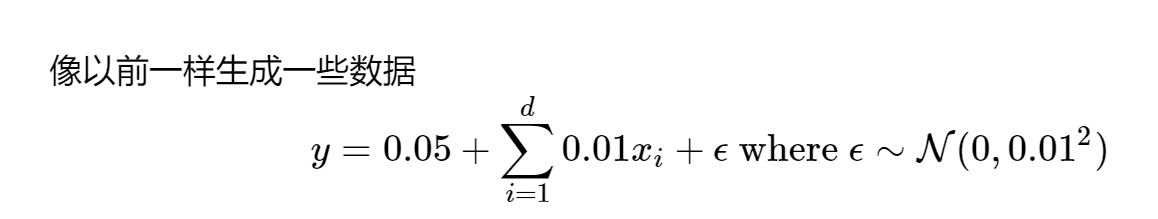

In [22]:
#故意让n_train很小，这样会过拟合
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
#这里的w和b是数据真实的权重和偏置
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
#d2l.synthetic_data生成训练和测试数据 
#d2l.load_array把数据传进来
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)
true_w.shape

torch.Size([200, 1])

## 初始化模型参数

In [27]:
#这里的w和b是模型要训练的，我们最想要和真实的w和b一致
def init_params():
    w=torch.normal(0,1,size=(num_inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True) #b是一个标量
    return [w,b]

## 定义L2范数惩罚

In [31]:
#w平方/2,这里没有把lamata写进来，会写进在外面
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

## 定义L1范数惩罚

In [61]:
def l1_penalty(w):
    return torch.sum(torch.abs(w))

## 定义训练代码

In [62]:
def train(lambd):
    w, b = init_params()
    #d2l.linreg(X, w, b)线性层 d2l.squared_loss平方差损失
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y) + lambd * l1_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    #torch.item()得到只有一个元素张量里面的元素值,跟数据是几维的没有关系，只要里面只有一个数据
    #torch.norm()求范数，默认是2范数
    print('w的L2范数是：', torch.norm(w).item()) 

w的L2范数是： 13.728952407836914


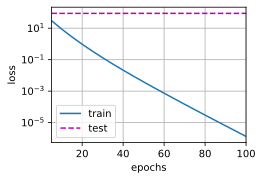

In [63]:
#忽略正则化直接训练 
#test loss基本没有变化
#train loss和test loss中间的gap一直扩大，这是非常严重的过拟合
train(lambd=0)

w的L2范数是： 0.24553675949573517


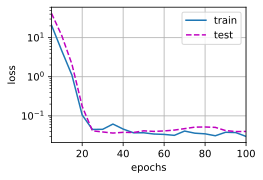

In [64]:
#lamata使得w不会变的特别大
#使用权重衰减
train(lambd=10)

w的L2范数是： 0.07028071582317352


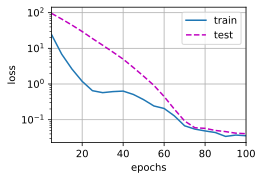

In [65]:
#lamata使得w不会变的特别大
#使用权重衰减
train(lambd=3)

w的L2范数是： 0.12076116353273392


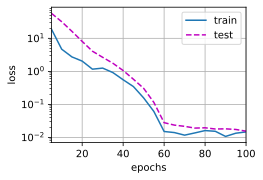

In [69]:
#lamata使得w不会变的特别大
#使用权重衰减
train(lambd=5)

w的L2范数是： 0.24707162380218506


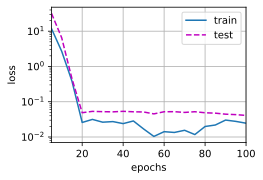

In [68]:
#lamata使得w不会变的特别大
#使用权重衰减
#lamata太大，会对训练误差产生很严重的扰动
train(lambd=10)

w的L2范数是： 0.4811265170574188


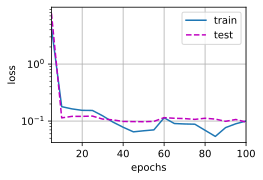

In [67]:
#lamata使得w不会变的特别大
#使用权重衰减
#lamata太大，会对训练误差产生很严重的扰动
train(lambd=20)

w的L2范数是： 0.7377752065658569


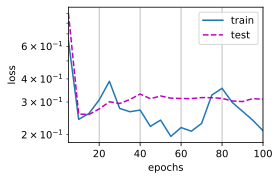

In [66]:
#lamata使得w不会变的特别大
#使用权重衰减
#lamata太大，会对训练误差产生很严重的扰动
train(lambd=30)

# 简洁实现

In [49]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    #这里多了一个 'weight_decay': wd
    trainer = torch.optim.SGD([{"params": net[0].weight, 'weight_decay': wd}, {"params": net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 15.164142608642578


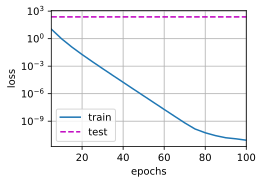

In [52]:
train_concise(0)

w的L2范数： 0.5698630213737488


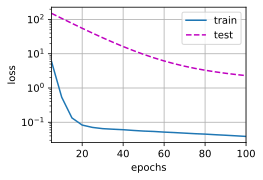

In [71]:
train_concise(3)

w的L2范数： 0.05371702089905739


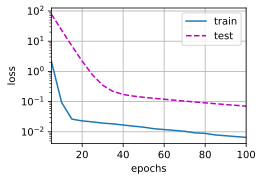

In [72]:
train_concise(10)

w的L2范数： 4.085183620452881


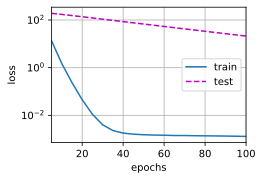

In [73]:
train_concise(1)

# 答疑

+ 若模型的权重参数选择范围很大的话，就可以选择很大或者很小的数据，这样曲线就会很不平滑  
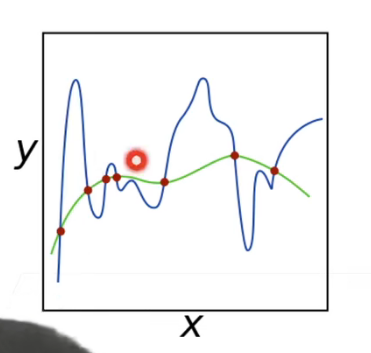
+ 限制参数选择范围，只能选择一些比较简单的模型，这样模型的复杂度就会低
+ 因为数据有噪音，学到的那个权重可能会很大，所以需要惩罚项，过大过小都不好，如果模型没有过拟合的话，惩罚项是没有用的
+ weight_decay的值一般是0.01、0.001
+ 

 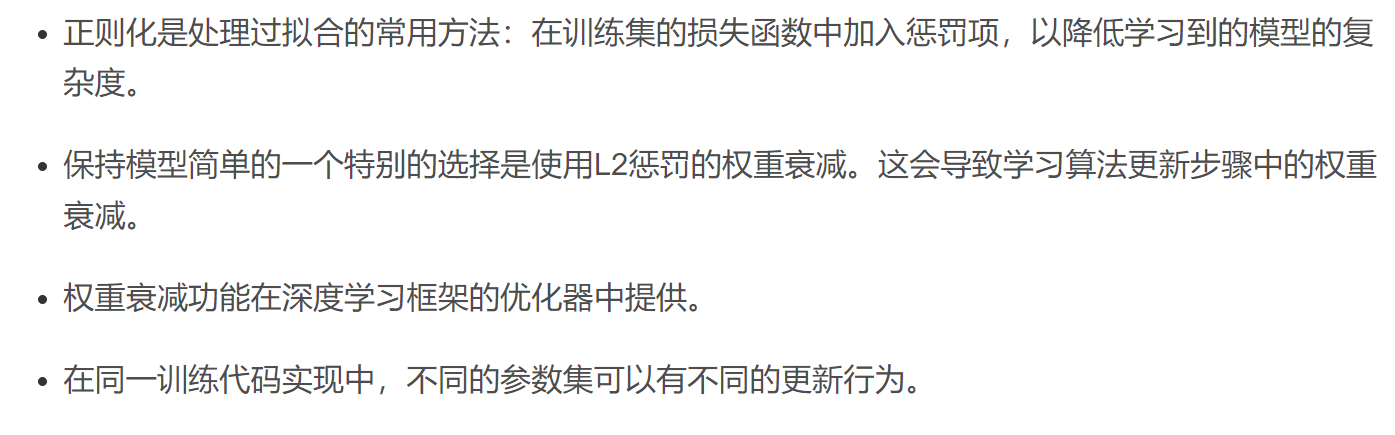

+ 权重衰减会应用到网络中所有需要学习的参数上面，然而如果仅仅将权重衰减应用到conv层和fc层的w参数，而对其biases参数和BN层的gamma和beta参数
不进行衰减，效果会更好。为什么呢？首先正则化主要是为了防止过拟合，而过拟合一般表现为模型对于输入的微小改变产生了输出的较大差异，
这主要是由于有些参数w过大的关系，通过对||w||进行惩罚，可以缓解这种问题。
+ 而如果对||b||进行惩罚，其实是没有作用的，因为在对输出结果的贡献中，参数b对于输入的改变是不敏感的，不管输入改变是大还是小，
参数b的贡献就只是加个偏置而已。举个例子，如果你在训练集中，w和b都表现得很好，但是在测试集上发生了过拟合，b是不背这个锅的，
因为它对于所有的数据都是一视同仁的（都只是给它们加个偏置），要背锅的是w，因为它会对不同的数据产生不一样的加权。或者说，
模型对于输入的微小改变产生了输出的较大差异，这是因为模型的“曲率”太大，而模型的曲率是由w决定的，
b不贡献曲率（对输入进行求导，b是直接约掉的）。另一方面，相比于weight，bias训练准确需要的数据要更少。
这意味着不对bias正则化，不会引入很多方差（variance）。同时，对bias进行正则化容易引起欠拟合。  
+  于是问题转化为如何将不期望添加正则化项的可训练参数 (如 BN 层的可训练参数及卷积层和全连接层的 bias) 从可训练参数列表中分离出来.